In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.distributions import normal, uniform
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
class DonutDataset():
    def __init__(self, size, seed=123):
        torch.manual_seed(seed)
        self.size = size
        scale = 1
        offset = 0
        
        norm = normal.Normal(6, 1)
        unif = uniform.Uniform(0, 1)
        r_n = norm.sample(sample_shape=torch.Size([size, 1]))
        uni_n = unif.sample(sample_shape=torch.Size([size, 1]))
        theta = 2.0 * np.pi * uni_n
        x = r_n * torch.cos(theta)
        y = r_n * torch.sin(theta)
        x = scale * x + offset
        y = scale * y + offset
        self.points = torch.cat([x, y], dim=1)
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.points[idx]
        return sample

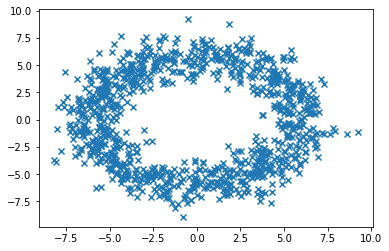

In [4]:
donut = DonutDataset(10000)
points = donut[np.arange(1000)]
plt.scatter(points[:, 0], points[:, 1], marker='x')
plt.show()

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        hidden_size = 8
        
        self.hidden0 = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return x

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        hidden_size = 8
        
        self.hidden0 = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(inplace=True)
        )
        self.hidden2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return x

In [7]:
def z_uniform(size, range_=10.0):
    unif = uniform.Uniform(-range_/2, range_/2)
    return unif.sample(sample_shape=torch.Size([size])).reshape(-1, 1)

In [8]:
def train_discriminator(real_data, gen_data, discriminator, optimizer):
    optimizer.zero_grad()
    
    real_pred = discriminator(real_data)
    real_loss = nn.BCELoss()(real_pred, torch.ones_like(real_pred))
    real_loss.backward()
    
    gen_pred = discriminator(gen_data)
    gen_loss = nn.BCELoss()(1 - gen_pred, torch.ones_like(gen_pred))
    gen_loss.backward()
    
    optimizer.step()
    
    return real_loss, gen_loss

In [9]:
def train_generator(z, generator, discriminator, optimizer):
    optimizer.zero_grad()
    
    gen_data = generator(z)
    gen_pred = discriminator(gen_data)
    gen_loss = nn.BCELoss()(gen_pred, torch.ones_like(gen_pred))
    gen_loss.backward()
    
    optimizer.step()
    
    return gen_loss

In [58]:
x = np.linspace(-10.0, 10.0, num=30)
y = np.linspace(10.0, -10.0, num=30)
grid = []
for i, y_ in enumerate(y):
    for j, x_ in enumerate(x):
        grid.append((x_, y_))
grid = np.array(grid)
grid = torch.tensor(grid, dtype=torch.float32)

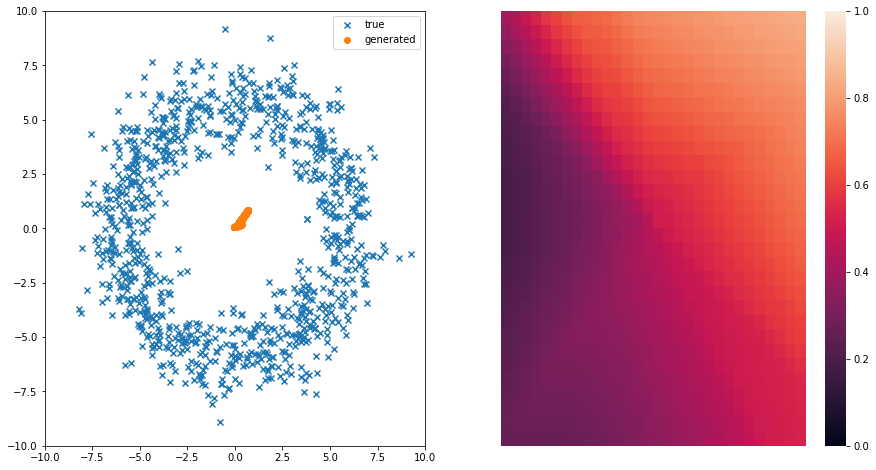

In [60]:
with torch.no_grad():
    torch.manual_seed(123)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle("Before training", fontsize=20)
    plt.subplot(121)
    generator = Generator()
    gen = generator(z_uniform(1000)).numpy()
    plt.scatter(points[:, 0], points[:, 1], marker='x', label='true')
    plt.scatter(gen[:, 0], gen[:, 1], marker='o', label='generated')
    plt.xlim(-10.0, 10.0)
    plt.ylim(-10.0, 10.0)
    plt.title('Distributions')
    plt.legend()
    
    plt.subplot(122)
    discriminator = Discriminator()
    dis = discriminator(grid).numpy()
    dis = dis.reshape(30, 30)
    ax = sns.heatmap(dis, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
    plt.title('Discriminator Probs for R^2; x,y E (-10, 10)')
    plt.show()

In [61]:
torch.manual_seed(123)
mini_batch_size = 128
lr_d = 0.0001
lr_g = 0.0001
d_steps = 5
g_steps = 5

dataloader = DataLoader(donut, batch_size=mini_batch_size,
                        shuffle=True, num_workers=1) 

discriminator = Discriminator()
generator = Generator()

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_g)

losses_g, losses_d = [], []

for epoch in range(400):
    _losses_d = []
    _losses_g = []
    for i, data in enumerate(dataloader):
        
        for _ in range(d_steps):
            gen_data = generator(z_uniform(mini_batch_size)).detach()
            loss_d_real, loss_d_gen = train_discriminator(data, gen_data, discriminator, d_optimizer)
            _losses_d.append(loss_d_real.item() + loss_d_gen.item())
        
        for _ in range(g_steps):
            z = z_uniform(mini_batch_size)
            loss_g = train_generator(z, generator, discriminator, g_optimizer)
            _losses_g.append(loss_g.item())
    
    losses_g.append(np.mean(_losses_g))
    losses_d.append(np.mean(_losses_d))
    if epoch % 5 == 0:
        print("Epoch: {}; D_loss: {}; G_loss: {}".format(
            epoch+1, np.mean(_losses_d), np.mean(_losses_g)))

Epoch: 1; D_loss: 1.271446762281128; G_loss: 0.5257028134563301
Epoch: 6; D_loss: 0.9256281527537333; G_loss: 0.6343492382689367
Epoch: 11; D_loss: 0.9264691656903375; G_loss: 0.7266936800147914
Epoch: 16; D_loss: 1.3909444731247576; G_loss: 0.8311250810381733
Epoch: 21; D_loss: 1.2495004524158526; G_loss: 0.7674494717694536
Epoch: 26; D_loss: 1.067529849689218; G_loss: 1.1559893236884589
Epoch: 31; D_loss: 1.0140946979009653; G_loss: 0.9547016456157347
Epoch: 36; D_loss: 1.2740724331970457; G_loss: 0.9555917145330695
Epoch: 41; D_loss: 1.0831122983860064; G_loss: 1.0195540532281127
Epoch: 46; D_loss: 1.2868340847612936; G_loss: 0.6941787583918511
Epoch: 51; D_loss: 1.0190546691417695; G_loss: 1.053744847261453
Epoch: 56; D_loss: 1.2399170036557354; G_loss: 1.1157892504824867
Epoch: 61; D_loss: 0.9218718219406997; G_loss: 1.061120646663859
Epoch: 66; D_loss: 0.9251887511603439; G_loss: 1.116115107113802
Epoch: 71; D_loss: 1.4235115523579756; G_loss: 0.8475680772262284
Epoch: 76; D_loss

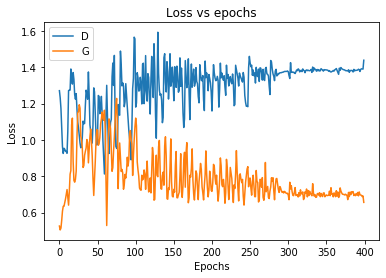

In [78]:
plt.plot(losses_d, label='D')
plt.plot(losses_g, label='G')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.show()

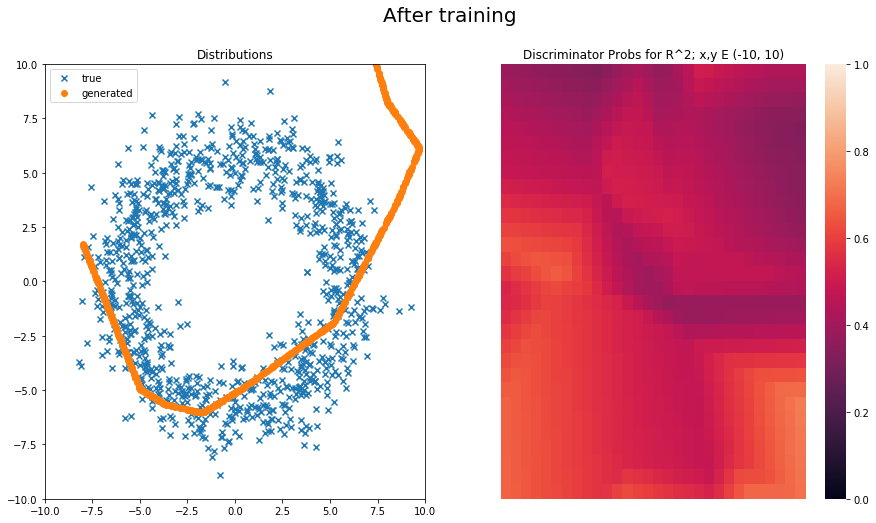

In [83]:
with torch.no_grad():
    plt.figure(figsize=(15, 8))
    plt.suptitle("After training", fontsize=20)
    plt.subplot(121)
    gen = generator(z_uniform(1000)).numpy()
    plt.scatter(points[:, 0], points[:, 1], marker='x', label='true')
    plt.scatter(gen[:, 0], gen[:, 1], marker='o', label='generated')
    plt.xlim(-10.0, 10.0)
    plt.ylim(-10.0, 10.0)
    plt.title('Distributions')
    plt.legend()
    
    plt.subplot(122)
    dis = discriminator(grid).numpy()
    dis = dis.reshape(30, 30)
    ax = sns.heatmap(dis, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
    plt.title('Discriminator Probs for R^2; x,y E (-10, 10)')
    plt.show()